**Its a notebook of BERT along with Dense Layer as Feedforward Network: Bert-2**

In [ ]:
!nvidia-smi

Tue Jul  6 11:22:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import Library

In [ ]:
!pip install -q tensorflow-text
!pip install -q tf-models-official
!pip install -q tfds-nightly

In [ ]:
import os
import shutil

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds
from official.nlp import optimization
import tensorflow_addons as tfa

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
#Connect to the TPU worker
"""
if os.environ['COLAB_TPU_ADDR']:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
elif tf.test.is_gpu_available():
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recommended.')"""

"\nif os.environ['COLAB_TPU_ADDR']:\n  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')\n  tf.config.experimental_connect_to_cluster(cluster_resolver)\n  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)\n  strategy = tf.distribute.TPUStrategy(cluster_resolver)\n  print('Using TPU')\nelif tf.test.is_gpu_available():\n  strategy = tf.distribute.MirroredStrategy()\n  print('Using GPU')\nelse:\n  raise ValueError('Running on CPU is not recommended.')"

In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


### Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
train_df=pd.read_csv('/content/drive/MyDrive/sarcasm/reddit/Reddit-train.csv')
valid_df=pd.read_csv('/content/drive/MyDrive/sarcasm/reddit/Reddit-valid.csv')
test_df=pd.read_csv('/content/drive/MyDrive/sarcasm/reddit/Reddit-test.csv')

In [ ]:
train_df.shape, valid_df.shape, test_df.shape

((24937, 4), (3117, 4), (3118, 4))

In [ ]:
#Change Column heere
column_='pair'

In [ ]:
import numpy as np
train_df[column_].replace('', np.nan, inplace=True)
train_df[column_].replace('nan', np.nan, inplace=True)
train_df.dropna(subset=[column_], inplace=True)

In [ ]:
train_df[column_]=train_df[column_].astype(str)

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((train_df[column_].values, train_df['label'].values))
valid_data = tf.data.Dataset.from_tensor_slices((valid_df[column_].values, valid_df['label'].values))

### Model Build

In [ ]:
bert_preprocess_model_handle = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
bert_model_handle = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"
#hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"

In [ ]:
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

In [ ]:
def build_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(bert_preprocess_model_handle, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(bert_model_handle, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
 # ext= outputs['all_layer_output']

  #net = tf.keras.layers.Dropout(0.1)(net)
  #net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  #return tf.keras.Model(text_input, net)

  net = tf.keras.layers.Dropout(0.3)(net)

  net = tf.keras.layers.Dense(768, activation="relu", name="Dense2")(net)
  #net = tf.keras.layers.Dropout(0.3)(net)
  --->net = tf.keras.layers.Dropout(0.3)(net)
  net = tf.keras.layers.Dense(384, activation="relu", name="Dense1")(net)
  #net = tf.keras.layers.Dropout(0.2)(net)
  #net = tf.keras.layers.Dense(192, activation="relu", name="Dense2")(net)
  #net = tf.keras.layers.Dropout(0.3)(net)
  #net = tf.keras.layers.Dense(128, activation="relu", name="Dense3")(net)
  net = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(net)
  return tf.keras.Model(text_input, net)



### Model-1

In [ ]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'sequence_output':  109482241   preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
______________________________________________________________________________________________

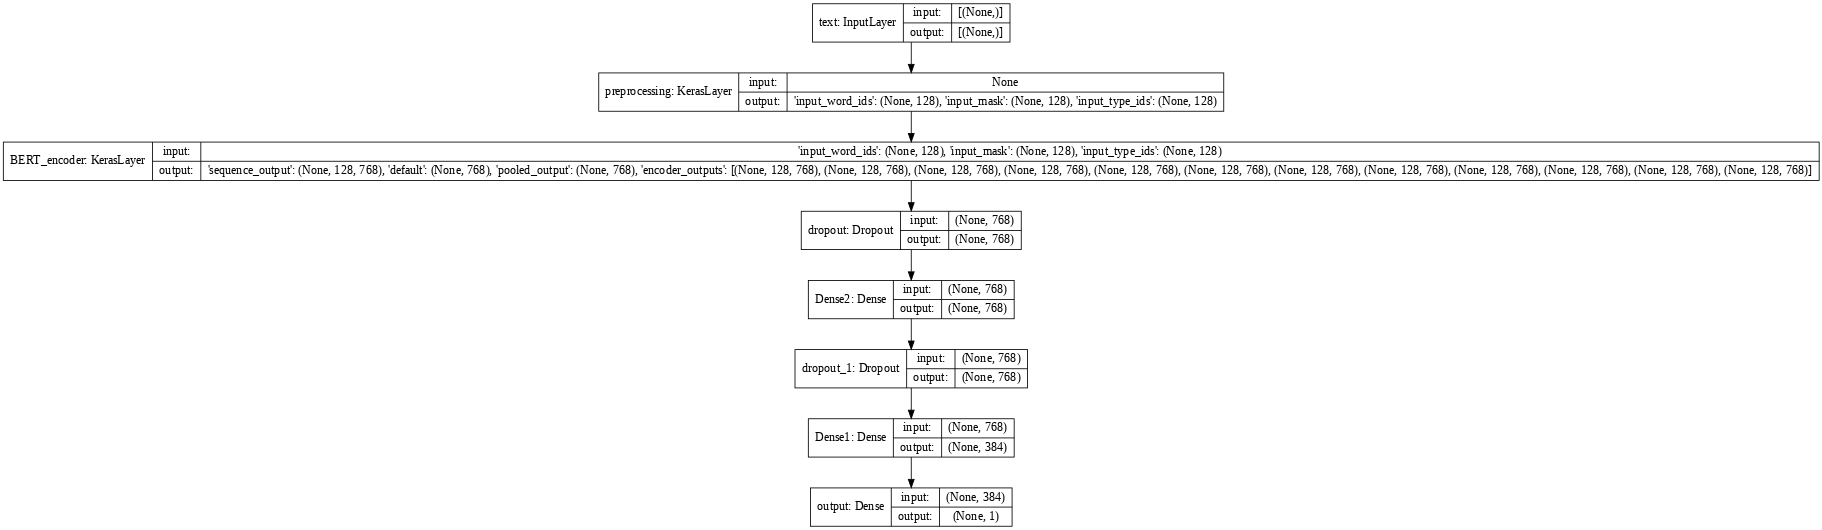

In [ ]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=60 )

### Set Parameters

In [ ]:
epochs = 20
steps_per_epoch = tf.data.experimental.cardinality(train_data).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 2e-5 *
opt = optimization.create_optimizer(init_lr=init_lr, num_train_steps=num_train_steps, num_warmup_steps=num_warmup_steps, optimizer_type='adamw')

In [ ]:
model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1, restore_best_weights=True)

### Training

In [ ]:
history = model.fit(x=train_data, epochs=epochs, validation_data=valid_data, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
780/780 [==============================] - 443s 550ms/step - loss: 0.7229 - binary_accuracy: 0.4930 - val_loss: 0.6953 - val_binary_accuracy: 0.4998
Epoch 2/20
780/780 [==============================] - 428s 549ms/step - loss: 0.7080 - binary_accuracy: 0.5118 - val_loss: 0.6824 - val_binary_accuracy: 0.5666
Epoch 3/20
780/780 [==============================] - 428s 549ms/step - loss: 0.6767 - binary_accuracy: 0.5734 - val_loss: 0.6259 - val_binary_accuracy: 0.6471
Epoch 4/20
780/780 [==============================] - 428s 549ms/step - loss: 0.6277 - binary_accuracy: 0.6518 - val_loss: 0.5929 - val_binary_accuracy: 0.6805
Epoch 5/20
780/780 [==============================] - 428s 549ms/step - loss: 0.5959 - binary_accuracy: 0.6906 - val_loss: 0.5672 - val_binary_accuracy: 0.7097
Epoch 6/20
780/780 [==============================] - 428s 549ms/step - loss: 0.5643 - binary_accuracy: 0.7153 - val_loss: 0.5555 - val_binary_accuracy: 0.7180
Epoch 7/20
780/780 [====================

In [ ]:
model.save("/content/drive/MyDrive/model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

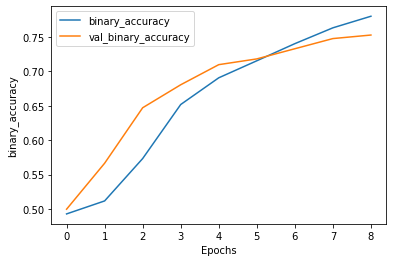

In [ ]:
plot_graphs(history, 'binary_accuracy')

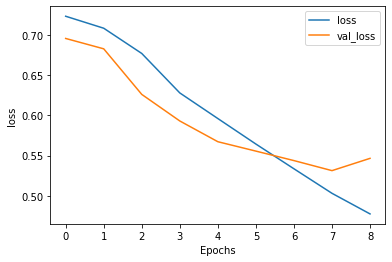

In [ ]:
plot_graphs(history, 'loss')

### Testing-1

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices((test_df[column_].values, test_df['label'].values))
predicted = model.predict([test_df[column_]])
pred=[1 if p >=0.5 else 0 for p in predicted]
from pandas import DataFrame
pred_df = DataFrame (pred,columns=['pred_label'])
true_label = test_df["label"]
from sklearn.metrics import precision_score,recall_score,f1_score, accuracy_score
accuracy_score(true_label,pred_df),precision_score(true_label,pred_df),recall_score(true_label,pred_df),f1_score(true_label,pred_df)


(0.7389352148813342, 0.7535738597685501, 0.710070558050032, 0.7311756935270806)

In [ ]:
"""from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(true_label, pred_df)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')

plot_roc_curve(fpr, tpr)
plt.show()"""

"from sklearn.metrics import roc_curve\nimport matplotlib.pyplot as plt\n\nfpr, tpr, thresholds = roc_curve(true_label, pred_df)\n\ndef plot_roc_curve(fpr, tpr, label=None):\n  plt.plot(fpr, tpr, linewidth=2, label=label)\n  plt.plot([0, 1], [0, 1], 'k--')\n\nplot_roc_curve(fpr, tpr)\nplt.show()"

In [ ]:
"""from sklearn.metrics import roc_auc_score
roc_auc_score(true_label, pred_df)"""

'from sklearn.metrics import roc_auc_score\nroc_auc_score(true_label, pred_df)'